In [13]:
%load_ext autoreload
%autoreload 2
from catboost import CatBoostRegressor, Pool, cv, CatBoostClassifier
from src import MetaInfo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score,roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_data = pd.read_parquet("data/train.parquet")
test_data = pd.read_parquet("data/test.parquet")


In [3]:
manager = MetaInfo(train_data,fill_churn=60)

In [4]:
X = manager.generate_meta_features()
y = manager.get_labels()

In [5]:
# X.head()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [7]:
train_data['buy_post'].sum() / len(train_data)

0.796484553543692

In [8]:
reg_params = {
    'loss_function': 'RMSE',
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 4,
    'l2_leaf_reg': 3,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 100,
    'scale_pos_weight': 4
}
clf_params = {
    'loss_function': 'Logloss',  # Logloss for binary classification
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 3,
    'l2_leaf_reg': 2,
    'od_type': 'Iter',
    'od_wait': 20,
    'verbose': 100,
    'scale_pos_weight': 4
}


In [9]:
y_train['buy_post'].values

array([0, 0, 1, ..., 0, 0, 1])

In [10]:
final_model = CatBoostClassifier(
    loss_function="Logloss",
    iterations=2000,
    learning_rate=0.06,
    depth=4,
    l2_leaf_reg=2,
    scale_pos_weight=4,
    verbose=100
)
final_model.fit(X_train.values, y_train['buy_post'].values)


0:	learn: 0.6313173	total: 78.1ms	remaining: 2m 36s
100:	learn: 0.2787013	total: 2.22s	remaining: 41.8s
200:	learn: 0.2785732	total: 4.22s	remaining: 37.8s
300:	learn: 0.2784763	total: 6.4s	remaining: 36.1s
400:	learn: 0.2784018	total: 8.42s	remaining: 33.6s
500:	learn: 0.2783319	total: 10.5s	remaining: 31.4s
600:	learn: 0.2782850	total: 12.6s	remaining: 29.3s
700:	learn: 0.2782484	total: 14.7s	remaining: 27.3s
800:	learn: 0.2782173	total: 16.6s	remaining: 24.9s
900:	learn: 0.2781948	total: 18.6s	remaining: 22.7s
1000:	learn: 0.2781603	total: 20.9s	remaining: 20.9s
1100:	learn: 0.2781363	total: 22.9s	remaining: 18.7s
1200:	learn: 0.2781144	total: 24.9s	remaining: 16.6s
1300:	learn: 0.2780897	total: 27.1s	remaining: 14.6s
1400:	learn: 0.2780678	total: 29.2s	remaining: 12.5s
1500:	learn: 0.2780457	total: 31.3s	remaining: 10.4s
1600:	learn: 0.2780200	total: 33.3s	remaining: 8.29s
1700:	learn: 0.2780005	total: 35.3s	remaining: 6.21s
1800:	learn: 0.2779681	total: 37.6s	remaining: 4.15s
1900

In [11]:
clf_pred_proba = final_model.predict_proba(X_test.values)

In [75]:
# np.sqrt(
#     mean_squared_error(
#         y_test['date_diff_post'],
#         clf_pred
#     )
# ) 

39.722827037848

In [90]:
# # plt.hist(clf_pred)
# clf_pred.sum() / len(clf_pred)

0.999769696969697

In [15]:
# prediction_ = np.array(clf_pred, dtype=np.int64)
# f1_score(
#     y_test['buy_post'],
#     prediction_
    
# ), balanced_accuracy_score(
#     y_test['buy_post'],
#     prediction_
# )

In [16]:
clf_pred_proba[:,1]

array([0.87325844, 0.88049618, 0.6443994 , ..., 0.91908163, 0.86248241,
       0.80981307])

ROC-AUC Score: 0.7034915267619763


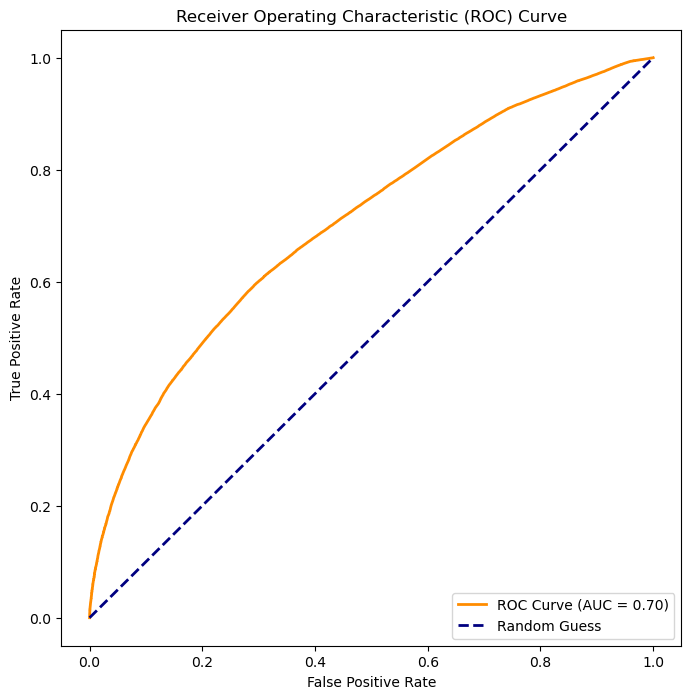

In [17]:
roc_auc = roc_auc_score(y_test['buy_post'].values, clf_pred_proba[:,1])
print(f'ROC-AUC Score: {roc_auc}')


fpr, tpr, _ = roc_curve(y_test['buy_post'].values, clf_pred_proba[:,1])

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# from sklearn.metrics import balanced_accuracy_score
# binary_true = y_test['buy_post'].values

# binary_predictions = np.array((cl<67),dtype=int)
# # binary_true = np.array((y_ <=100),dtype=int)
# f1_score(binary_true, binary_predictions), balanced_accuracy_score(binary_true, binary_predictions)